### Generative AI for Digit using GAN

Develop sets of characters, to train a GAN on Arabic Handwritten digits and use it to create new symbols for representing digits on an alien planet.

#### Problem Statement:
You are working with a team that is developing an online game where users travel to an alien planet and try to learn the language, culture, religion, and science of the planetary society. The game designers would like a set of characters to represent digits, different from any of those used on earth. To develop this set of characters, your job is to train a GAN on Arabic Handwritten digits and use it to create new symbols for representing digits on an alien planet.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, BatchNormalization, Conv2DTranspose, Activation
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping


import warnings

warnings.filterwarnings('ignore')

In [2]:
# Load the dataset from CSV files
train_images = pd.read_csv('csvTrainImages 60k x 784.csv', header=None)  # 60k x 784
train_labels = pd.read_csv('csvTrainLabel 60k x 1.csv', header=None)  # 60k x 1
test_images = pd.read_csv('csvTestImages 10k x 784.csv', header=None)    # 10k x 784
test_labels = pd.read_csv('csvTestLabel 10k x 1.csv', header=None)     # 10k x 1

In [3]:
train_images.head()

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  777  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   778  779  780  781  782  783  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 784 columns]

In [4]:
train_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 784 entries, 0 to 783
dtypes: int64(784)
memory usage: 358.9 MB


In [5]:
# Convert the dataframes to numpy arrays
train_images = train_images.values
train_labels = train_labels.values
test_images = test_images.values
test_labels = test_labels.values

In [6]:
# Print the shape of the datasets
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing images shape: {test_images.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training images shape: (60000, 784)
Training labels shape: (60000, 1)
Testing images shape: (10000, 784)
Testing labels shape: (10000, 1)


In [7]:
# Normalize the images to the range [0, 1] by dividing by 255
train_images = train_images / 255.0
test_images = test_images / 255.0

In [8]:
# Reshape the images to 28x28x1 (grayscale)
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

In [9]:
print(f"Training images shape: {train_images.shape}")
print(f"Testing images shape: {test_images.shape}")

Training images shape: (60000, 28, 28, 1)
Testing images shape: (10000, 28, 28, 1)


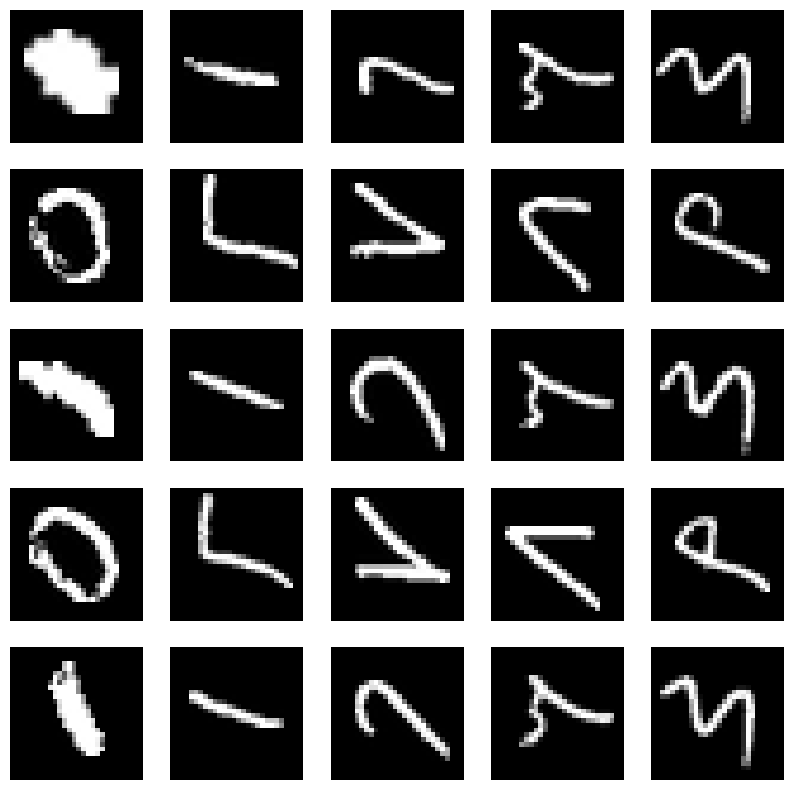

In [10]:
# Check the first 25 images from the training set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

#  Generating Real and Fake Samples

In [11]:
# Function to generate real samples from the training data
def realData(batch_size, train_images):
    # Select a random batch of real images from the training data
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_images = train_images[idx]
    # Rescale to [-1, 1]
    real_images = (real_images.astype(np.float32) - 127.5) / 127.5
    real_images = real_images.reshape(batch_size, 28, 28, 1)
    return real_images

# Function to generate random latent vectors for the generator input
def fakeInputs(batch_size, latent_dim):
    return np.random.randn(batch_size, latent_dim)

# Define the Generator Model

In [12]:
# Define the generator model
# Generator Model
def genModel(infeats=100):
    Genmodel = Sequential()
    # Fully connected layer with 512 units
    Genmodel.add(Dense(512, input_dim=infeats))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    
    # Second layer: Dense -> ReLU -> BatchNormalization
    Genmodel.add(Dense(7 * 7 * 64))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    
    # Reshape to 7x7x64 feature maps
    Genmodel.add(Reshape((7, 7, 64)))
    
    # Upsample to 14x14 using Conv2DTranspose
    Genmodel.add(Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization(axis=-1))
    
    # Upsample to 28x28 and output the final image
    Genmodel.add(Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    Genmodel.add(Activation('tanh'))  # Final layer should output values in range [-1, 1]
    
    return Genmodel



In [13]:
# Define generator
latent_dim = 100  # Latent dimension 
generator = genModel(infeats=latent_dim)
# generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
generator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 3136)              1608768   
                                                                 
 activation_1 (Activation)   (None, 3136)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 3136)              12544     
 chNormalization)                                     

In [14]:
# Function to generate fake samples using the generator model
def fakedataGenerator(Genmodel, batch_size, latent_dim):
    # Generate random inputs (latent vectors) for the generator
    genInputs = fakeInputs(batch_size, latent_dim)
    # Use the generator to create fake images
    X_fake = Genmodel.predict(genInputs)
    return X_fake

# Define the Discriminator Model

In [16]:
# Discriminator Model
def discModel():
    Discmodel = Sequential()
    # Conv layer 1: 32 filters, 5x5 kernel, stride 2
    Discmodel.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    Discmodel.add(LeakyReLU(0.2))
    
    # Conv layer 2: 64 filters, 5x5 kernel, stride 2
    Discmodel.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    Discmodel.add(LeakyReLU(0.2))
    
    # Flatten and fully connected layers
    Discmodel.add(Flatten())
    Discmodel.add(Dense(512))
    Discmodel.add(LeakyReLU(0.2))
    Discmodel.add(Dense(1, activation='sigmoid'))  # Output a single value between 0 and 1
    
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    # Compile the discriminator
    Discmodel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return Discmodel

In [17]:
# Define discriminator
discriminator = discModel()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1606144   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)              

# Define and Compile the GAN Model

In [20]:
# Define the combined GAN model
def ganModel(Genmodel, Discmodel):
    # Make discriminator untrainable for the GAN model
    Discmodel.trainable = False
    Ganmodel = Sequential()
    
    # Add the generator to the model
    Ganmodel.add(Genmodel)
    
    # Add the discriminator to the model (this is where the fake images are classified as real or fake)
    Ganmodel.add(Discmodel)
    
    # Compile the GAN model
    Ganmodel.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return Ganmodel

In [21]:
# Define GAN
gan_model = ganModel(generator, discriminator)
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1727233   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1658753   
                                                                 
Total params: 3385986 (12.92 MB)
Trainable params: 1719873 (6.56 MB)
Non-trainable params: 1666113 (6.36 MB)
_________________________________________________________________


# Training the GAN

In [22]:
# Training the GAN
nEpochs = 10000  # Number of epochs
batch_size = 128  # Batch size

# Train the GAN network
for epoch in range(nEpochs):
    # Generate real images and labels
    x_real = realData(batch_size, train_images)
    
    # Generate fake images
    x_fake = fakedataGenerator(generator, batch_size, latent_dim)
    
    # Concatenate real and fake images
    X = np.concatenate([x_real, x_fake])
    
    # Labels: 1 for real images, 0 for fake images
    Y = np.zeros(batch_size * 2)
    Y[:batch_size] = 1  # Real images are labeled as 1
    
    # Train the discriminator on real and fake data
    discLoss = discriminator.train_on_batch(X, Y)
    
    # Generate fake inputs to train the generator via the GAN model
    x_gan = fakeInputs(batch_size * 2, latent_dim)
    y_gan = np.ones((batch_size * 2, 1))  # Labels: 1 to fool the discriminator
    
    # Train the generator via the GAN model
    gan_model.train_on_batch(x_gan, y_gan)
    
    # Print the loss every 50 epochs for monitoring
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Discriminator Loss: {discLoss[0]} | Discriminator Accuracy: {discLoss[1]}")


4/4 [==============================] - 1s 17ms/step


Epoch: 0 | Discriminator Loss: 0.6573288440704346 | Discriminator Accuracy: 0.84375
4/4 [==============================] - 0s 18ms/step
Epoch: 50 | Discriminator Loss: 0.00033319887006655335 | Discriminator Accuracy: 1.0
4/4 [==============================] - 0s 20ms/step
Epoch: 100 | Discriminator Loss: 0.00014021896640770137 | Discriminator Accuracy: 1.0
4/4 [==============================] - 0s 8ms/step
Epoch: 150 | Discriminator Loss: 0.00019628251902759075 | Discriminator Accuracy: 1.0
4/4 [==============================] - 0s 13ms/step
Epoch: 200 | Discriminator Loss: 0.002203939016908407 | Discriminator Accuracy: 1.0
4/4 [==============================] - 0s 18ms/step
Epoch: 250 | Discriminator Loss: 0.0003627347759902477 | Discriminator Accuracy: 1.0
4/4 [==============================] - 0s 11ms/step
Epoch: 300 | Discriminator Loss: 0.14526595175266266 | Discriminator Accuracy: 1.0
4/4 [==============================] - 0s 

# Generate and Display Fake Images

In [23]:
# method 1
# Function to generate fake images and plot them
def generate_and_plot_images(generator, latent_dim, n_samples=25):
    noise = np.random.randn(n_samples, latent_dim)
    fake_images = generator.predict(noise)
    
    # Plot the generated images in a 5x5 grid
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(fake_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 277ms/step


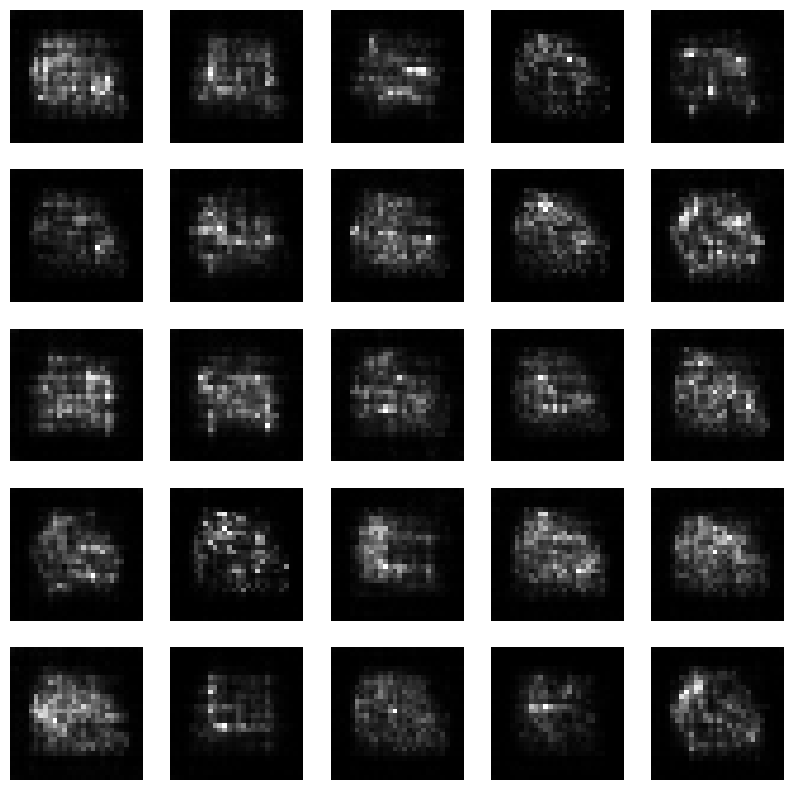

In [24]:
# Generate and plot 25 fake images
generate_and_plot_images(generator, latent_dim)

1/1 [==============================] - 0s 45ms/step


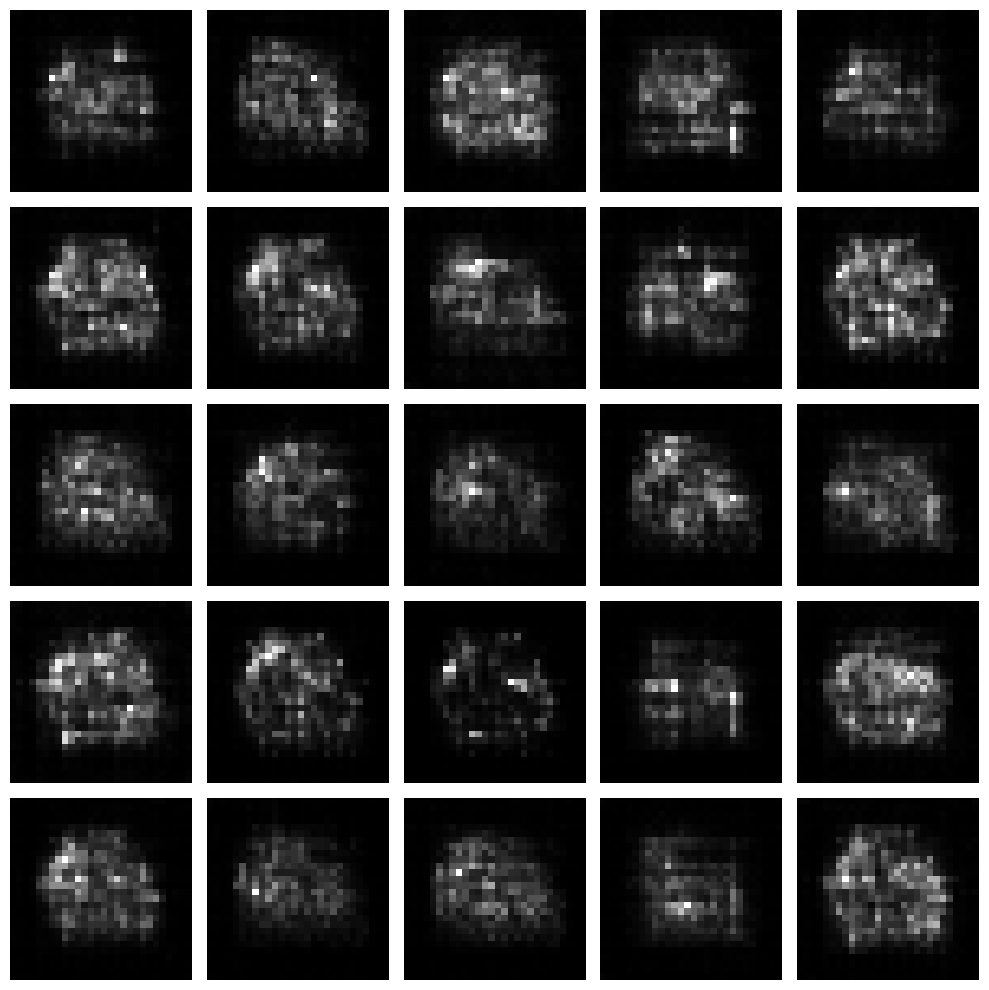

In [25]:
# method 2

# Generate 25 fake images from the generator model
def generate_fake_images(generator, num_images, latent_dim):
    # Generate random latent inputs for the generator
    z = np.random.randn(num_images, latent_dim)
    fake_images = generator.predict(z)
    return fake_images

# Set the number of fake images to generate
num_images = 25
latent_dim = 100  # Latent dimension (e.g., 100)
fake_images = generate_fake_images(generator, num_images, latent_dim)

# Rescale the generated images from [-1, 1] to [0, 1] for display purposes
fake_images_rescaled = (fake_images + 1) / 2.0

# Display the fake images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(fake_images_rescaled[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# Select the best 10 fake images

1/1 [==============================] - 0s 287ms/step


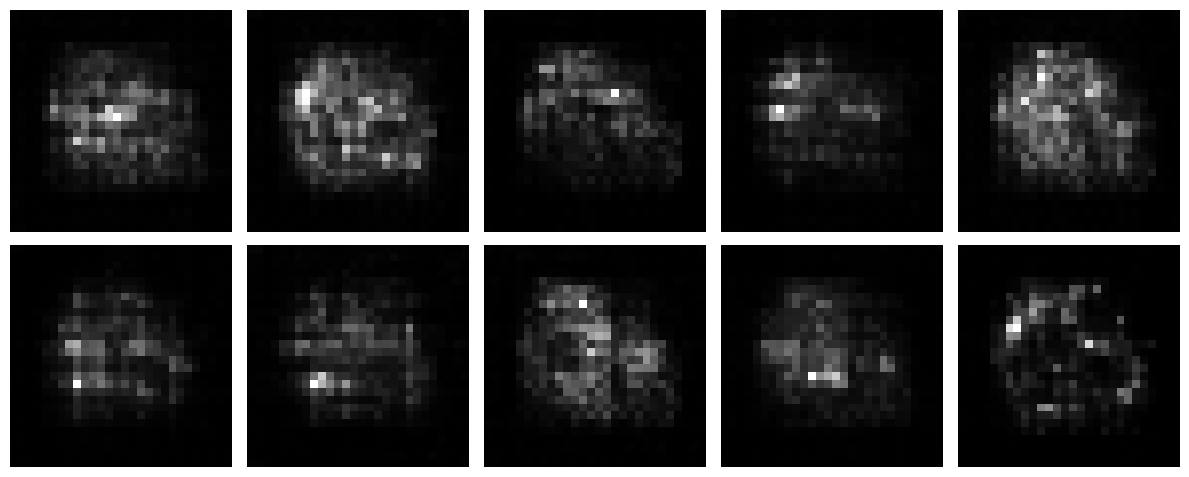

In [26]:
'''# Select the best 10 images 
best_images = fake_images[:10]  

# Plot the 10 best images in a 5x2 grid
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(best_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

'''

# Generate fake images using the best version of the generator model
best_fake_images = generate_fake_images(generator, 10, latent_dim)

# Rescale the images for display
best_fake_images_rescaled = (best_fake_images + 1) / 2.0

# Display the best 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(best_fake_images_rescaled[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


## Observation on the selected 10

The images were blurry, and the generator and discriminator often oscillated without showing meaningful improvement. This is a typical case of non convergence 

# Generator model 2

In [28]:
# Define the generator model
def define_generator(latent_dim):
    model = Sequential()
    # Fully connected layer to create initial vector
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    # Add batch normalization and upsampling layers
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))  # Final layer
    
    return model

# Define latent dimension (size of random noise vector)
latent_dim = 100
generator_2 = define_generator(latent_dim)
generator_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_6 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 14, 14, 128)       147584    
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 128)      

# Discriminator 2

In [29]:
# Define the discriminator model
def define_discriminator(input_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Output a single value between 0 and 1
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    # Compile the discriminator
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the discriminator model
discriminator_2 = define_discriminator()
discriminator_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

# Gan Model 2

In [30]:
# Define the GAN model
def define_gan(generator, discriminator):
    # Make the discriminator untrainable when training the GAN
    discriminator.trainable = False
    
    # GAN input is noise (latent space) passed to the generator
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    
    # Discriminator takes generated image as input and classifies it
    gan_output = discriminator(x)
    
    # Define the GAN model
    model = Model(gan_input, gan_output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    
    return model

# Define and compile the GAN model
gan_2 = define_gan(generator_2, discriminator_2)
gan_2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         856705    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 80769     
                                                                 
Total params: 937474 (3.58 MB)
Trainable params: 856065 (3.27 MB)
Non-trainable params: 81409 (318.00 KB)
_________________________________________________________________


# Train Model 2

In [32]:
# Training the GAN
nEpochs = 20000  # Number of epochs
batch_size = 128  # Batch size

# Train the GAN network
for epoch in range(nEpochs):
    # Generate real images and labels
    x_real = realData(batch_size, train_images)
    
    # Generate fake images
    x_fake = fakedataGenerator(generator_2, batch_size, latent_dim)
    
    # Concatenate real and fake images
    X = np.concatenate([x_real, x_fake])
    
    # Labels: 1 for real images, 0 for fake images
    Y = np.zeros(batch_size * 2)
    Y[:batch_size] = 1  # Real images are labeled as 1
    
    # Train the discriminator on real and fake data
    discLoss = discriminator_2.train_on_batch(X, Y)
    
    # Generate fake inputs to train the generator via the GAN model
    x_gan = fakeInputs(batch_size * 2, latent_dim)
    y_gan = np.ones((batch_size * 2, 1))  # Labels: 1 to fool the discriminator
    
    # Train the generator via the GAN model
    gan_2.train_on_batch(x_gan, y_gan)
    
    # Print the loss every 50 epochs for monitoring
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Discriminator Loss: {discLoss[0]} | Discriminator Accuracy: {discLoss[1]}")

4/4 [==============================] - 1s 96ms/step
Epoch: 0 | Discriminator Loss: 0.6779406666755676 | Discriminator Accuracy: 0.58984375
4/4 [==============================] - 0s 42ms/step
Epoch: 50 | Discriminator Loss: 0.6676878929138184 | Discriminator Accuracy: 0.51171875
4/4 [==============================] - 0s 42ms/step
Epoch: 100 | Discriminator Loss: 0.6909027695655823 | Discriminator Accuracy: 0.5390625
4/4 [==============================] - 0s 42ms/step
Epoch: 150 | Discriminator Loss: 0.6902082562446594 | Discriminator Accuracy: 0.5078125
4/4 [==============================] - 0s 45ms/step
Epoch: 200 | Discriminator Loss: 0.6991564035415649 | Discriminator Accuracy: 0.4765625
4/4 [==============================] - 0s 58ms/step
Epoch: 250 | Discriminator Loss: 0.691765308380127 | Discriminator Accuracy: 0.53125
4/4 [==============================] - 0s 42ms/step
Epoch: 300 | Discriminator Loss: 0.69465172290802 | Discriminator Accuracy: 0.49609375
4/4 [====================

# Generate 25 fake images with model 2

1/1 [==============================] - 1s 597ms/step


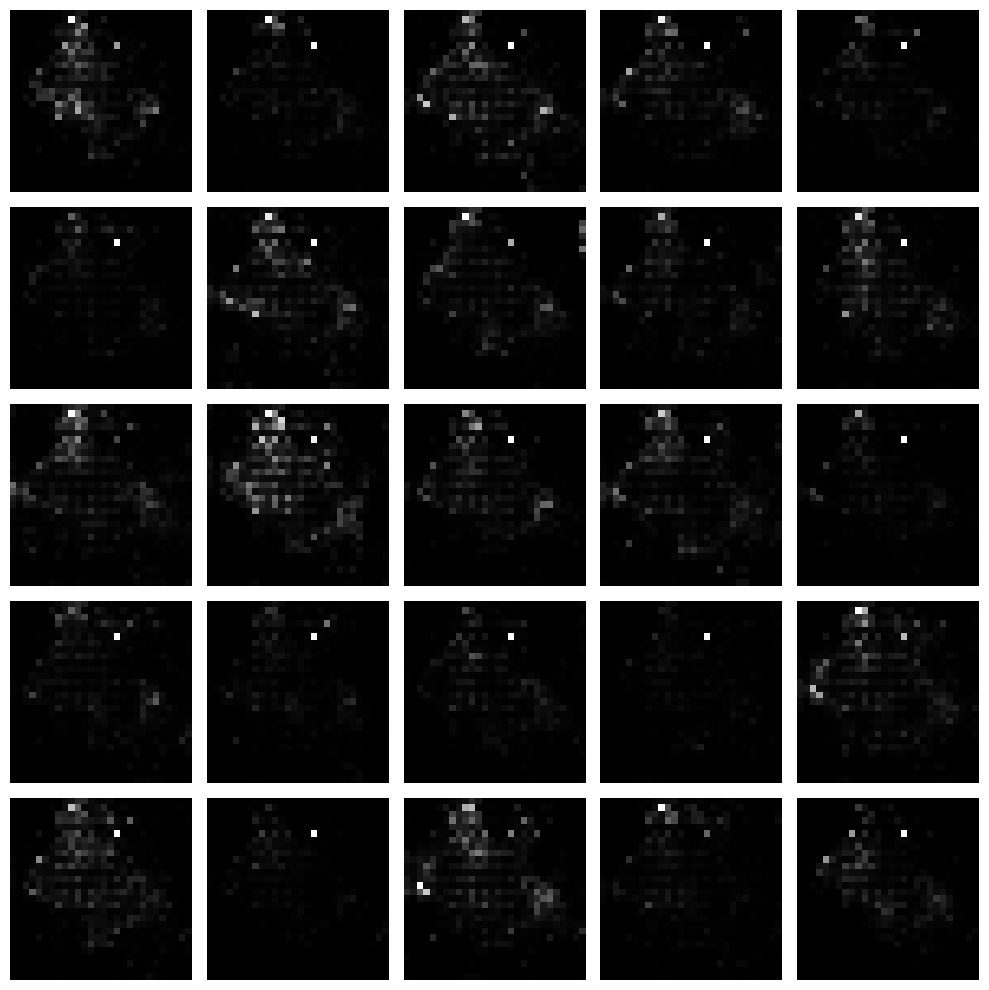

In [34]:
# Set the number of fake images to generate
num_images = 25
latent_dim = 100  # Latent dimension (e.g., 100)
fake_images_2 = generate_fake_images(generator_2, num_images, latent_dim)

# Rescale the generated images from [-1, 1] to [0, 1] for display purposes
fake_images_rescaled_2 = (fake_images_2 + 1) / 2.0

# Display the fake images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(fake_images_rescaled_2[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# Select the best 10 from the 25

The Same issue with model 1 above

## Regularize Model 1 by adding Noise to fool the discriminator 

## Generator Model 3

In [37]:
# Define the generator model
def define_generator(latent_dim):
    model = Sequential()
    # Fully connected layer to create initial 7x7x128 tensor
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))  # Reshape to image-like tensor
    # First upsampling block
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    # Second upsampling block
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    # Output layer
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))  # Grayscale output [-1, 1]
    return model

# Define latent dimension (size of random noise vector)
latent_dim = 100
generator_3 = define_generator(latent_dim)
generator_3.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_12 (Ba  (None, 7, 7, 128)         512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_11 (Conv2  (None, 14, 14, 128)       147584    
 DTranspose)                                                     
                                                                 
 batch_normalization_13 (Ba  (None, 14, 14, 128)      

## Discriminator 3

In [39]:
# Define the discriminator model
def define_discriminator(input_shape=(28, 28, 1)):
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))  # Dropout to reduce overfitting
    
    # Second Conv Block
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    # Flatten and Dense Output
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Output a single value between 0 and 1
    
    # Compile the model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Instantiate and summarize the model
discriminator_3 = define_discriminator()
discriminator_3.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)            

## Combined GAN Model 3

In [41]:
# Define the combined GAN model
def ganModel(generator, discriminator):
    # Ensure the discriminator's weights are not updated during generator training
    discriminator.trainable = False
    
    # Input for the GAN: random noise vector
    gan_input = Input(shape=(generator.input_shape[1],))
    
    # Pass the input through the generator to create fake images
    fake_image = generator(gan_input)
    
    # Pass the fake images through the discriminator to classify as real or fake
    gan_output = discriminator(fake_image)
    
    # Define the GAN model (connects generator and discriminator)
    gan_3 = Model(gan_input, gan_output, name="GAN")
    
    # Compile the GAN model
    gan_3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    
    return gan_3

# Define GAN
gan_3_model = ganModel(generator, discriminator)
gan_3_model.summary()


Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         1727233   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1658753   
                                                                 
Total params: 3385986 (12.92 MB)
Trainable params: 1719873 (6.56 MB)
Non-trainable params: 1666113 (6.36 MB)
_________________________________________________________________


## Train Model 3

In [60]:
# Hyperparameters
nEpochs = 10000  # Number of epochs
batch_size = 128  # Batch size
latent_dim = 100  # Latent space dimension
lr_generator = 0.0002  # Generator learning rate
lr_discriminator = 0.0001  # Discriminator learning rate
beta_1 = 0.5  # Adam optimizer beta_1 parameter

# Optimizers
generator_optimizer = Adam(lr_generator, beta_1=beta_1)
discriminator_optimizer = Adam(lr_discriminator, beta_1=beta_1)

# Compile models with custom learning rates and metrics
generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Save generated images for progress visualization
def save_images(epoch, generator, latent_dim, n_images=25):
    noise = np.random.normal(0, 1, (n_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=(5, 5))
    for i in range(n_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_epoch_{epoch}.png")
    plt.close()

In [61]:
# Training the GAN
for epoch in range(nEpochs):
    # Generate real and fake data
    x_real, y_real = realData(batch_size, train_images), np.ones((batch_size, 1)) * 0.9  # Label smoothing
    x_fake, y_fake = fakedataGenerator(generator, batch_size, latent_dim), np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(x_real, y_real)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)  # Average loss for real and fake

    # Train the generator via GAN
    noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Generate noise
    y_gan = np.ones((batch_size, 1))  # Labels for GAN training (all ones to trick the discriminator)
    g_loss = gan_4_model.train_on_batch(noise, y_gan)

    # Print loss and accuracy every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Discriminator Loss: {d_loss:.4f}, Accuracy: {d_acc_real:.4f} | Generator Loss: {g_loss:.4f}")
        save_images(epoch, generator, latent_dim)

    # Early stopping criteria
    if epoch > 100 and abs(d_loss - g_loss) < 0.001:
        print(f"Early stopping at epoch {epoch}.")
        break  


4/4 [==============================] - 0s 15ms/step
Epoch: 0 | Discriminator Loss: 0.8453, Accuracy: 0.0000 | Generator Loss: 0.6225
4/4 [==============================] - 0s 16ms/step
Epoch: 50 | Discriminator Loss: 1.5070, Accuracy: 0.0000 | Generator Loss: 0.2627
4/4 [==============================] - 0s 10ms/step
Epoch: 100 | Discriminator Loss: 2.0301, Accuracy: 0.0000 | Generator Loss: 0.1365
4/4 [==============================] - 0s 12ms/step
Epoch: 150 | Discriminator Loss: 2.2722, Accuracy: 0.0000 | Generator Loss: 0.0391
4/4 [==============================] - 0s 15ms/step
Epoch: 200 | Discriminator Loss: 2.5287, Accuracy: 0.0000 | Generator Loss: 0.0170
4/4 [==============================] - 0s 10ms/step
Epoch: 250 | Discriminator Loss: 2.7043, Accuracy: 0.0000 | Generator Loss: 0.0112
4/4 [==============================] - 0s 17ms/step
Epoch: 300 | Discriminator Loss: 2.8228, Accuracy: 0.0000 | Generator Loss: 0.0088
4/4 [==============================] - 0s 10ms/step
Epoch:

In [ ]:
# Hyperparameters
nEpochs = 10000  # Number of epochs
batch_size = 128  # Batch size
latent_dim = 100  # Latent space dimension
lr_generator = 0.0002  # Generator learning rate
lr_discriminator = 0.0001  # Discriminator learning rate
beta_1 = 0.5  # Adam optimizer beta_1 parameter

# Optimizers
generator_optimizer = Adam(lr_generator, beta_1=beta_1)
discriminator_optimizer = Adam(lr_discriminator, beta_1=beta_1)

# Compile models with custom learning rates and metrics
generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Save generated images for progress visualization
def save_images(epoch, generator, latent_dim, n_images=25):
    noise = np.random.normal(0, 1, (n_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=(5, 5))
    for i in range(n_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_epoch_{epoch}.png")
    plt.close()

# Train the GAN network
for epoch in range(nEpochs):
    # Generate real images and labels
    x_real = realData(batch_size, train_images)
    
    # Generate fake images with reduced noise
    x_fake = fakedataGenerator(generator, batch_size, latent_dim)
    noise = np.random.normal(0, 0.05, x_fake.shape)  # Reduced noise level
    x_fake += noise
    
    # Concatenate real and fake images
    X = np.concatenate([x_real, x_fake])
    
    # Labels: 1 for real images, 0 for fake images
    Y = np.zeros(batch_size * 2)
    Y[:batch_size] = 1  # Real images are labeled as 1
    
    # Train the discriminator on real and fake data
    discLoss = discriminator.train_on_batch(X, Y)
    
    # Generate fake inputs to train the generator via the GAN model
    x_gan = fakeInputs(batch_size * 2, latent_dim)
    y_gan = np.ones((batch_size * 2, 1))  # Labels: 1 to fool the discriminator
    
    # Train the generator via the GAN model
    gan_3_model.train_on_batch(x_gan, y_gan)
    
    # Save generated images for progress visualization
    if epoch % 50 == 0:
        save_images(epoch, generator, latent_dim)
        print(f"Epoch: {epoch} | Discriminator Loss: {discLoss[0]} | Discriminator Accuracy: {discLoss[1]}")
    
    # Implement early stopping manually if losses stabilize
    if epoch > 100 and np.abs(discLoss[0] - gan_loss) < 0.001:
        print(f"Training stopped early at epoch {epoch}.")
        break

1/1 [==============================] - 0s 283ms/step
Epoch: 0 | Discriminator Loss: 5.1885833740234375 | Discriminator Accuracy: 0.0
1/1 [==============================] - 0s 52ms/step
Epoch: 50 | Discriminator Loss: 5.245060920715332 | Discriminator Accuracy: 0.0
1/1 [==============================] - 0s 63ms/step
Epoch: 100 | Discriminator Loss: 5.285191059112549 | Discriminator Accuracy: 0.0
1/1 [==============================] - 0s 47ms/step
Epoch: 150 | Discriminator Loss: 5.330852508544922 | Discriminator Accuracy: 0.0
1/1 [==============================] - 0s 63ms/step
Epoch: 200 | Discriminator Loss: 5.349766254425049 | Discriminator Accuracy: 0.0
1/1 [==============================] - 0s 63ms/step
Epoch: 250 | Discriminator Loss: 5.371347904205322 | Discriminator Accuracy: 0.0
1/1 [==============================] - 0s 47ms/step
Epoch: 300 | Discriminator Loss: 5.423984527587891 | Discriminator Accuracy: 0.0
1/1 [==============================] - 0s 64ms/step
Epoch: 350 | Discr

## Generate and Display Images for Model 3

In [62]:
# method 1
# Function to generate fake images and plot them
def generate_and_plot_images(generator, latent_dim, n_samples=25):
    noise = np.random.randn(n_samples, latent_dim)
    fake_images = generator.predict(noise)
    
    # Plot the generated images in a 5x5 grid
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(fake_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

## Generate 25 Fake Images from the Generator Model 3

1/1 [==============================] - 0s 64ms/step


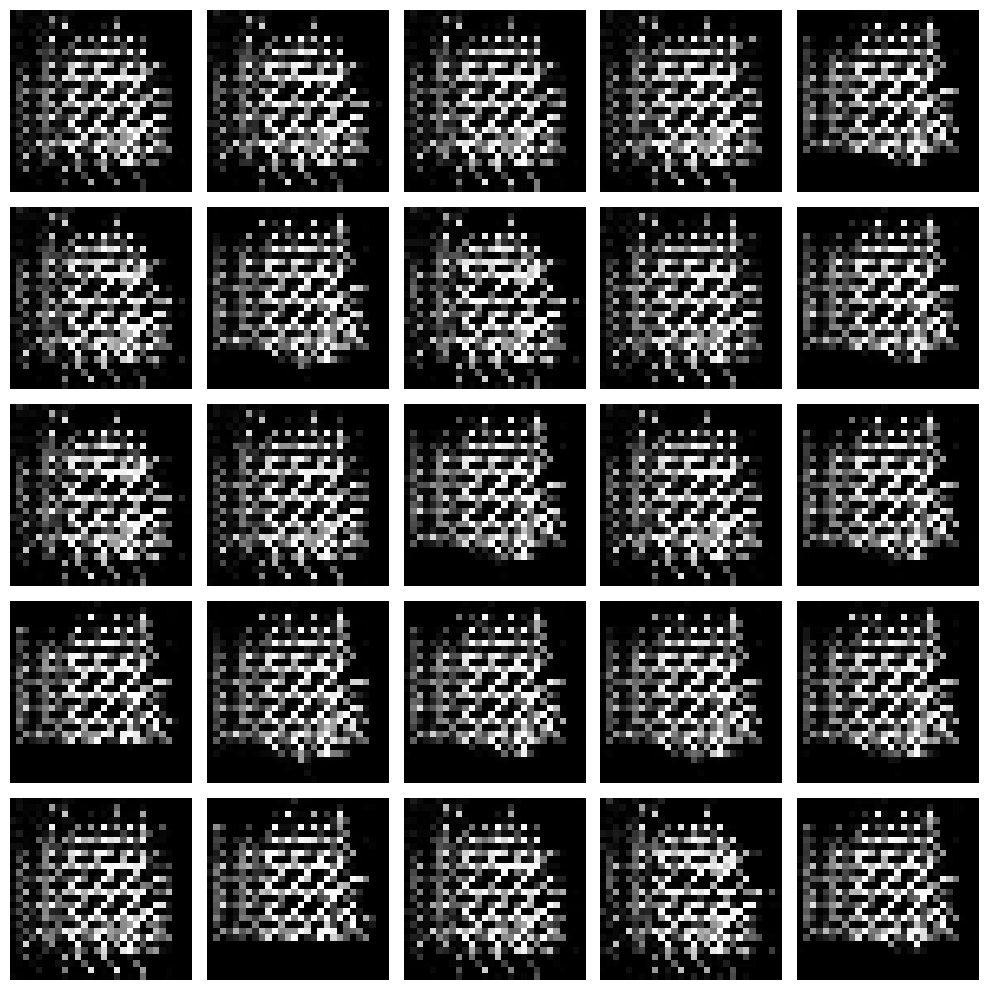

In [63]:
# method 2

# Generate 25 fake images from the generator model
def generate_fake_images(generator, num_images, latent_dim):
    # Generate random latent inputs for the generator
    z = np.random.randn(num_images, latent_dim)
    fake_images = generator.predict(z)
    return fake_images

# Set the number of fake images to generate
num_images = 25
latent_dim = 100  # Latent dimension (e.g., 100)
fake_images = generate_fake_images(generator, num_images, latent_dim)

# Rescale the generated images from [-1, 1] to [0, 1] for display purposes
fake_images_rescaled = (fake_images + 1) / 2.0

# Display the fake images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(fake_images_rescaled[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

## Select the Best 10 Images from Model 3

1/1 [==============================] - 0s 64ms/step


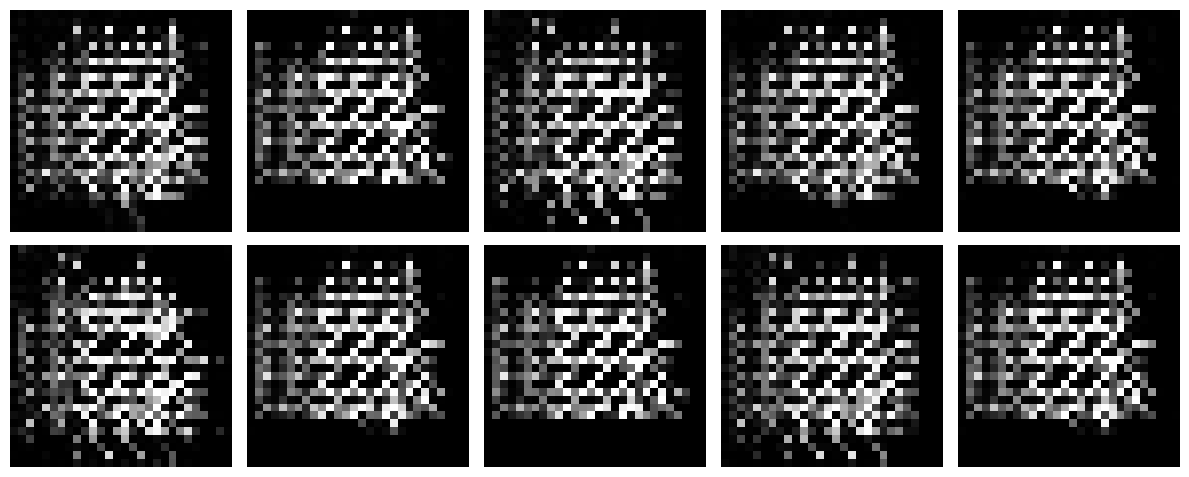

In [64]:
'''# Select the best 10 images 
best_images = fake_images[:10]  

# Plot the 10 best images in a 5x2 grid
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(best_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

'''

# Generate fake images using the best version of the generator model
best_fake_images = generate_fake_images(generator, 10, latent_dim)

# Rescale the images for display
best_fake_images_rescaled = (best_fake_images + 1) / 2.0

# Display the best 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(best_fake_images_rescaled[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


Despite hyperparameter tuning and adding noise to challenge the discriminator, the model exhibited mode collapse, producing limited and repetitive outputs.

## Gen Model 4

In [48]:
# Define the generator model
def define_generator(latent_dim):
    model = Sequential()
    # Fully connected layer to create initial 7x7x128 tensor
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))  # Reshape to image-like tensor
    # First upsampling block
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    # Second upsampling block
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    # Output layer
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))  # Grayscale output [-1, 1]
    return model

# Define latent dimension (size of random noise vector)
latent_dim = 100
generator_4 = define_generator(latent_dim)
generator_4.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 6272)              633472    
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_15 (Ba  (None, 7, 7, 128)         512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_14 (Conv2  (None, 14, 14, 128)       147584    
 DTranspose)                                                     
                                                                 
 batch_normalization_16 (Ba  (None, 14, 14, 128)     

## Discriminator 4

In [49]:
# Define the discriminator model
def define_discriminator(input_shape=(28, 28, 1)):
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))  # Dropout to reduce overfitting
    
    # Second Conv Block
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    # Flatten and Dense Output
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Output a single value between 0 and 1
    
    # Compile the model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Instantiate and summarize the model
discriminator_4 = define_discriminator()
discriminator_4.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_5 (Flatten)         (None, 6272)            

## Combinbed GAN Model 4 

In [51]:
# Define the combined GAN model
def ganModel(generator, discriminator):
    # Ensure the discriminator's weights are not updated during generator training
    discriminator.trainable = False
    
    # Input for the GAN: random noise vector
    gan_input = Input(shape=(generator.input_shape[1],))
    
    # Pass the input through the generator to create fake images
    fake_image = generator(gan_input)
    
    # Pass the fake images through the discriminator to classify as real or fake
    gan_output = discriminator(fake_image)
    
    # Define the GAN model (connects generator and discriminator)
    gan_4 = Model(gan_input, gan_output, name="GAN")
    
    # Compile the GAN model
    gan_4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    
    return gan_4

# Define GAN
gan_4_model = ganModel(generator, discriminator)
gan_4_model.summary()


Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         1727233   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1658753   
                                                                 
Total params: 3385986 (12.92 MB)
Trainable params: 1719873 (6.56 MB)
Non-trainable params: 1666113 (6.36 MB)
_________________________________________________________________


## Train Model 4

In [56]:
# Hyperparameters
nEpochs = 10000  # Number of epochs
batch_size = 128  # Batch size
latent_dim = 100  # Latent space dimension
lr_generator = 0.0002  # Generator learning rate
lr_discriminator = 0.0001  # Discriminator learning rate
beta_1 = 0.5  # Adam optimizer beta_1 parameter

# Optimizers
generator_optimizer = Adam(lr_generator, beta_1=beta_1)
discriminator_optimizer = Adam(lr_discriminator, beta_1=beta_1)

# Compile models with custom learning rates
generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)

# Save generated images for progress visualization
def save_images(epoch, generator, latent_dim, n_images=25):
    noise = np.random.normal(0, 1, (n_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=(5, 5))
    for i in range(n_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_epoch_{epoch}.png")
    plt.close()

# Training the GAN
for epoch in range(nEpochs):
    # Generate real and fake data
    x_real, y_real = realData(batch_size, train_images), np.ones((batch_size, 1)) * 0.9  # Label smoothing
    x_fake, y_fake = fakedataGenerator(generator, batch_size, latent_dim), np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(x_real, y_real)
    d_loss_fake = discriminator.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator via GAN
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    y_gan = np.ones((batch_size, 1))  # Generator tries to trick the discriminator
    g_loss = gan_4_model.train_on_batch(noise, y_gan)

    # Print loss and accuracy every 50 epochs
    if epoch % 50 == 0:
       print(f"Epoch: {epoch} | Discriminator Loss: {d_loss:.4f} | Generator Loss: {g_loss:.4f}")
    save_images(epoch, generator, latent_dim)

    # Early stopping criteria
    if epoch > 100 and abs(d_loss[0] - g_loss) < 0.001:
        print(f"Early stopping at epoch {epoch}.")
        break


4/4 [==============================] - 0s 11ms/step
Epoch: 0 | Discriminator Loss: 0.6940 | Generator Loss: 0.7792
4/4 [==============================] - 0s 14ms/step
Epoch: 50 | Discriminator Loss: 0.7031 | Generator Loss: 0.7547
4/4 [==============================] - 0s 11ms/step
Epoch: 100 | Discriminator Loss: 0.7527 | Generator Loss: 0.6836
1/1 [==============================] - 0s 62ms/step


IndexError: invalid index to scalar variable.

## Generate and Display Images for Model 4

In [67]:
# method 1
# Function to generate fake images and plot them
def generate_and_plot_images(generator, latent_dim, n_samples=25):
    noise = np.random.randn(n_samples, latent_dim)
    fake_images = generator.predict(noise)
    
    # Plot the generated images in a 5x5 grid
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(fake_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

## Generate 25 Fake Images from the Generator Model 4

1/1 [==============================] - 0s 64ms/step


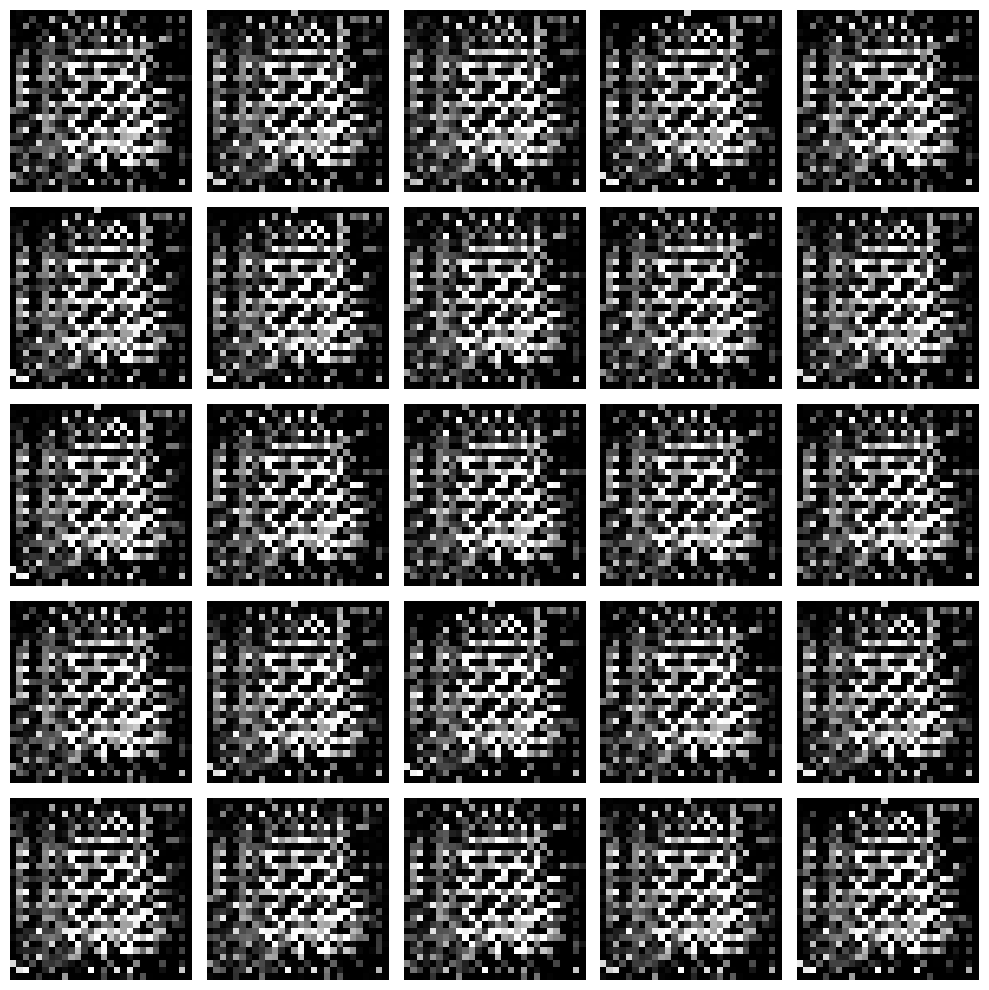

In [68]:
# method 2

# Generate 25 fake images from the generator model
def generate_fake_images(generator, num_images, latent_dim):
    # Generate random latent inputs for the generator
    z = np.random.randn(num_images, latent_dim)
    fake_images = generator.predict(z)
    return fake_images

# Set the number of fake images to generate
num_images = 25
latent_dim = 100  # Latent dimension (e.g., 100)
fake_images = generate_fake_images(generator, num_images, latent_dim)

# Rescale the generated images from [-1, 1] to [0, 1] for display purposes
fake_images_rescaled = (fake_images + 1) / 2.0

# Display the fake images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(fake_images_rescaled[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

## Select the Best 10 Images for Model 4  

1/1 [==============================] - 0s 73ms/step


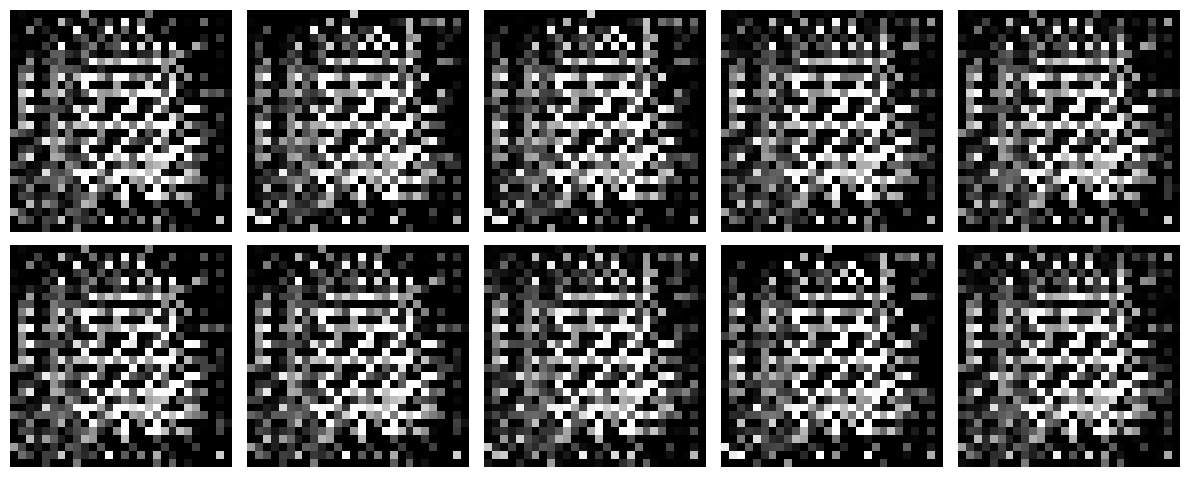

In [69]:
'''# Select the best 10 images 
best_images = fake_images[:10]  

# Plot the 10 best images in a 5x2 grid
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(best_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

'''

# Generate fake images using the best version of the generator model
best_fake_images = generate_fake_images(generator, 10, latent_dim)

# Rescale the images for display
best_fake_images_rescaled = (best_fake_images + 1) / 2.0

# Display the best 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(best_fake_images_rescaled[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
## Model 4 Observation

Same as model 3 above

In [ ]:
## Model 5 

In [82]:
# Hyperparameters
nEpochs = 20000  # Number of epochs
batch_size = 128  # Batch size
latent_dim = 100  # Latent space dimension
lr_generator = 0.0002  # Generator learning rate
lr_discriminator = 0.0001  # Discriminator learning rate
beta_1 = 0.5  # Adam optimizer beta_1 parameter

# Generator Model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28 * 28, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model


In [83]:
# Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [84]:
# GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    return gan


In [85]:
# Compile models
generator = build_generator(latent_dim)
discriminator = build_discriminator()

generator_optimizer = Adam(lr_generator, beta_1=beta_1)
discriminator_optimizer = Adam(lr_discriminator, beta_1=beta_1)

generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

gan_model = build_gan(generator, discriminator)
gan_model.compile(loss='binary_crossentropy', optimizer=generator_optimizer)

# Function to generate real data
def realData(batch_size, train_images):
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    x_real = train_images[idx]
    y_real = np.ones((batch_size, 1))
    return x_real, y_real

# Function to generate fake data
def fakedataGenerator(generator, batch_size, latent_dim):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    x_fake = generator.predict(noise)
    return x_fake

In [86]:
# Save generated images for progress visualization
def save_images(epoch, generator, latent_dim, n_images=25):
    noise = np.random.normal(0, 1, (n_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=(5, 5))
    for i in range(n_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_epoch_{epoch}.png")
    plt.close()

In [87]:
# Training the GAN
def train_gan(generator, discriminator, gan_model, train_images, latent_dim, nEpochs, batch_size):
    for epoch in range(nEpochs):
        # Generate real data
        x_real, y_real = realData(batch_size, train_images)
        
        # Generate fake data
        x_fake = fakedataGenerator(generator, batch_size, latent_dim)
        y_fake = np.zeros((batch_size, 1))
        
        # Train discriminator
        X = np.concatenate([x_real, x_fake])
        Y = np.concatenate([y_real, y_fake])
        discLoss = discriminator.train_on_batch(X, Y)
        
        # Train generator via GAN
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        y_gan = np.ones((batch_size, 1))
        gan_loss = gan_model.train_on_batch(noise, y_gan)
        
        # Save progress
        if epoch % 50 == 0:
            save_images(epoch, generator, latent_dim)
            print(f"Epoch: {epoch} | Discriminator Loss: {discLoss[0]} | Discriminator Accuracy: {discLoss[1]} | GAN Loss: {gan_loss}")



In [ ]:
# Load your dataset (e.g., MNIST)
from tensorflow.keras.datasets import mnist
(train_images, _), (_, _) = mnist.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
train_images = np.expand_dims(train_images, axis=-1)

# Start training
train_gan(generator, discriminator, gan_model, train_images, latent_dim, nEpochs, batch_size)


1/1 [==============================] - 0s 152ms/step
Epoch: 0 | Discriminator Loss: 0.5742987990379333 | Discriminator Accuracy: 0.62109375 | GAN Loss: 0.7145887017250061
1/1 [==============================] - 0s 47ms/step
Epoch: 50 | Discriminator Loss: 1.0418651103973389 | Discriminator Accuracy: 0.48828125 | GAN Loss: 0.5718761682510376
1/1 [==============================] - 0s 53ms/step
Epoch: 100 | Discriminator Loss: 0.84250807762146 | Discriminator Accuracy: 0.484375 | GAN Loss: 0.6588744521141052
1/1 [==============================] - 0s 53ms/step
Epoch: 150 | Discriminator Loss: 0.887042760848999 | Discriminator Accuracy: 0.38671875 | GAN Loss: 0.5842339992523193
1/1 [==============================] - 0s 49ms/step
Epoch: 200 | Discriminator Loss: 0.8527091145515442 | Discriminator Accuracy: 0.30859375 | GAN Loss: 0.5695769786834717
1/1 [==============================] - 0s 45ms/step
Epoch: 250 | Discriminator Loss: 0.7884474992752075 | Discriminator Accuracy: 0.43359375 | GAN 

In [ ]:
## 10000 Epoch 

In [79]:
# method 1 
# Function to generate fake images and plot them
def generate_and_plot_images(generator, latent_dim, n_samples=25):
    noise = np.random.randn(n_samples, latent_dim)
    fake_images = generator.predict(noise)
    
    # Plot the generated images in a 5x5 grid
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(fake_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 50ms/step


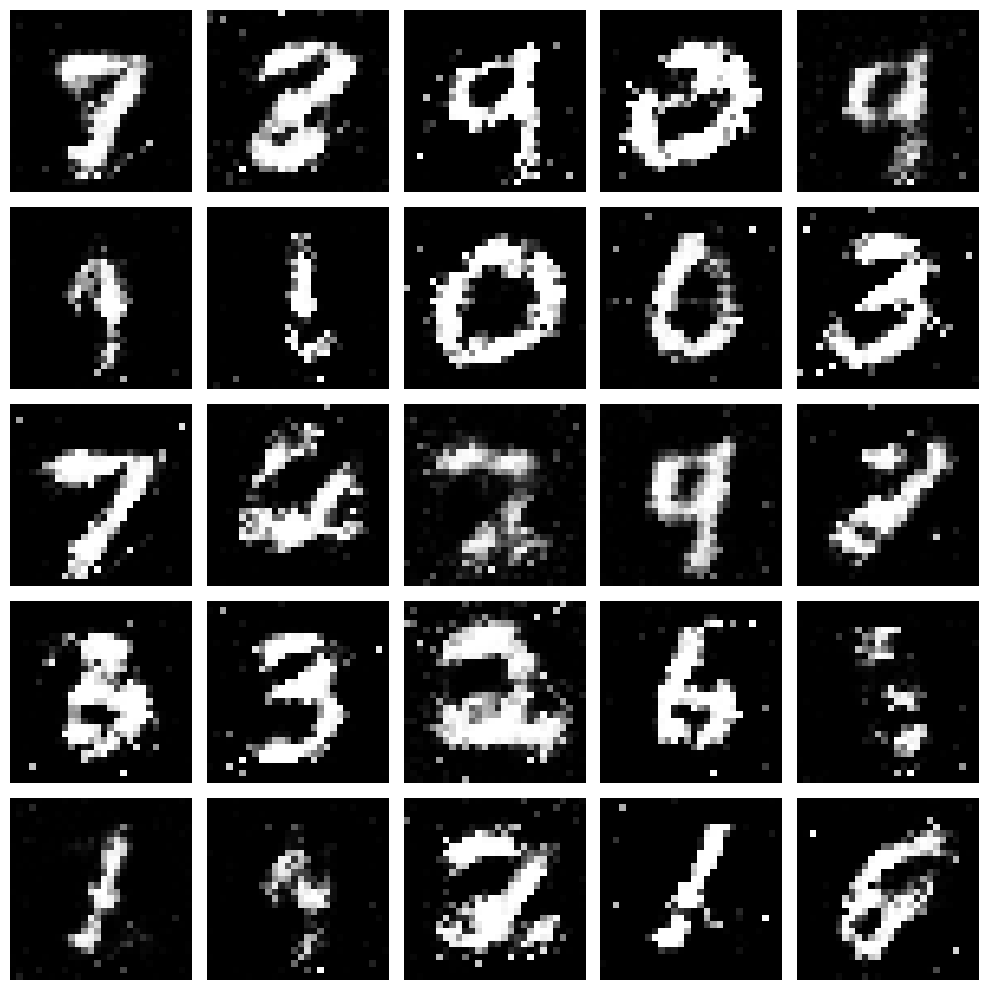

In [80]:
# method 2

# Generate 25 fake images from the generator model
def generate_fake_images(generator, num_images, latent_dim):
    # Generate random latent inputs for the generator
    z = np.random.randn(num_images, latent_dim)
    fake_images = generator.predict(z)
    return fake_images

# Set the number of fake images to generate
num_images = 25
latent_dim = 100  # Latent dimension (e.g., 100)
fake_images = generate_fake_images(generator, num_images, latent_dim)

# Rescale the generated images from [-1, 1] to [0, 1] for display purposes
fake_images_rescaled = (fake_images + 1) / 2.0

# Display the fake images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(fake_images_rescaled[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 217ms/step


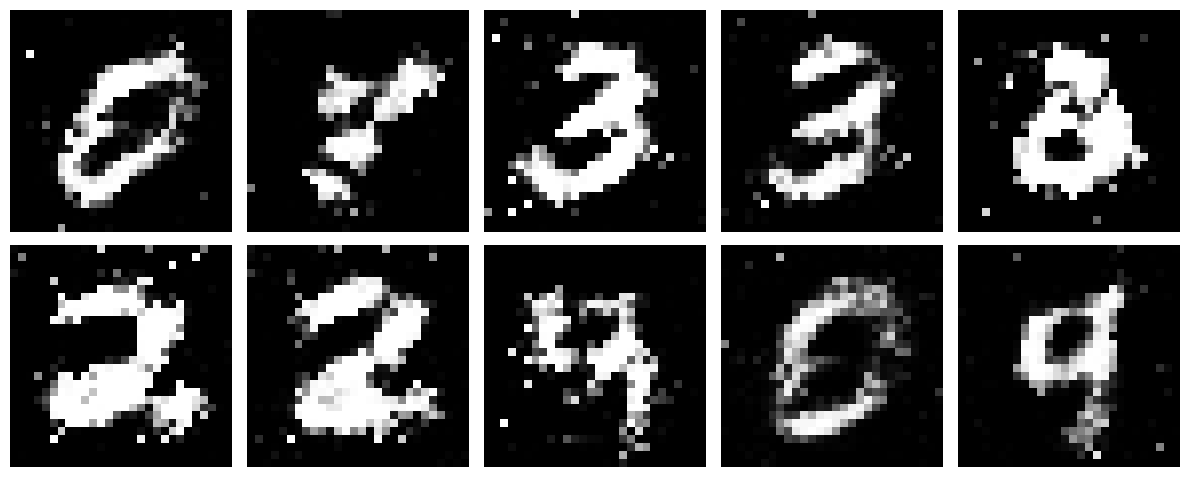

In [81]:
'''# Select the best 10 images 
best_images = fake_images[:10]  

# Plot the 10 best images in a 5x2 grid
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(best_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

'''

# Generate fake images using the best version of the generator model
best_fake_images = generate_fake_images(generator, 10, latent_dim)

# Rescale the images for display
best_fake_images_rescaled = (best_fake_images + 1) / 2.0

# Display the best 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(best_fake_images_rescaled[i * 5 + j, :, :, 0], cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()
